<a href="https://colab.research.google.com/github/Erikellerx/Projects_in_MLAI/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning

     |████████████████████████████████| 708 kB 7.6 MB/s 
     |████████████████████████████████| 529 kB 78.0 MB/s 


In [2]:
!nvidia-smi

Mon Oct 31 00:18:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [230]:
import pandas as pd
import seaborn as sn
import torch
import numpy as np
import tensorflow as tf
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchsummary import summary
import pytorch_lightning as pl
from IPython import display
pl.seed_everything(7)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import warnings
warnings.filterwarnings("ignore")

INFO:pytorch_lightning.utilities.seed:Global seed set to 7


In [5]:
class Net(pl.LightningModule):
    def __init__(self, net, lr):
        super().__init__()
        self.net = net
        self.lr = lr

        self.train_accuracy = Accuracy()
        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.net.parameters(), lr=self.lr, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler. OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=45000 ,
            )
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.net(x)
        loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        self.train_accuracy.update(preds, y)
 
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.net(x)
        val_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        self.val_accuracy.update(preds, y)
        
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.net(x)
        test_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)


# myCNN

In [67]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

batch = 256 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2,len(testset)-len(testset)//2])


valloader = torch.utils.data.DataLoader(validationset, batch_size=batch,
                                         shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
class myCNN(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
        self.fc = nn.Sequential(
            nn.Dropout(p=.5),
            nn.Linear(in_features=512*3*3, out_features=2048, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.5),
            nn.Linear(in_features=2048, out_features=10, bias=True)   
            )


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [69]:
summary(myCNN().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           9,472
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 256, 12, 12]         409,856
              ReLU-5          [-1, 256, 12, 12]               0
         MaxPool2d-6            [-1, 256, 6, 6]               0
            Conv2d-7            [-1, 512, 6, 6]       1,180,160
              ReLU-8            [-1, 512, 6, 6]               0
            Conv2d-9            [-1, 512, 6, 6]       2,359,808
             ReLU-10            [-1, 512, 6, 6]               0
        MaxPool2d-11            [-1, 512, 3, 3]               0
          Dropout-12                 [-1, 4608]               0
           Linear-13                 [-1, 2048]       9,439,232
             ReLU-14                 [-

In [13]:
model = Net(myCNN(), lr = 0.01)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=20,
    logger=CSVLogger(save_dir="myCNNlogs/"),
)

trainer.fit(model, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type     | Params
--------------------------------------------
0 | net            | myCNN    | 13.4 M
1 | train_accuracy | Accuracy | 0     
2 | val_accuracy   | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


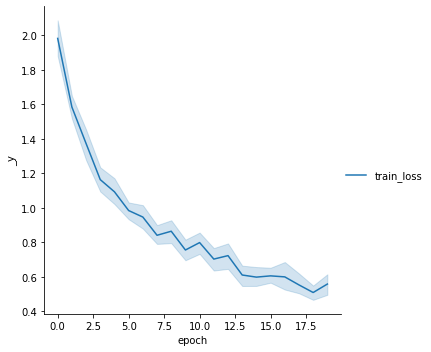

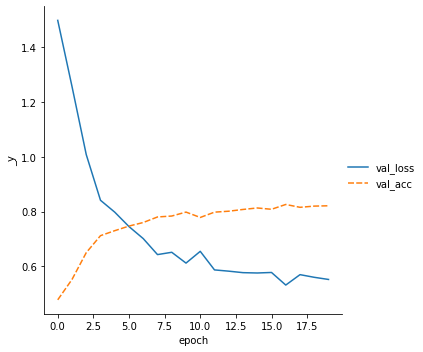

In [14]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
#display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[["train_loss"]], kind="line")
sn.relplot(data=metrics[["val_loss", "val_acc"]], kind="line")

In [15]:
trainer.test(model, testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.826200008392334
        test_loss           0.5342593193054199
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5342593193054199, 'test_acc': 0.826200008392334}]

# Resnet


In [73]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

batch = 256 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2,len(testset)-len(testset)//2])


valloader = torch.utils.data.DataLoader(validationset, batch_size=batch,
                                         shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [74]:
class ResBlock(nn.Module):
    
    def __init__(self, in_dim, out_dim, projection_shortcut):
        super().__init__()
        
        #Projecttion shortcut:  1×1 convolutions
        if projection_shortcut:      
            self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_size=3,stride=2, padding=1)    
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_dim)     
                )
        #identity shortcuts
        else:
            self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_size=3,stride=1, padding=1)
            self.shortcut = nn.Sequential()
        
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(out_dim)
        self.batchnorm2 = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU(inplace = True)
    
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x))) 
        x = x + shortcut
        x = self.relu(x)
        return x
            
        

class ResNet(nn.Module):
    
    def __init__(self,in_dim, out_dim):
        
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_dim, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.conv2_x = nn.Sequential(   
            ResBlock(64, 64, projection_shortcut=False),
            ResBlock(64, 64, projection_shortcut=False),
            ResBlock(64, 64, projection_shortcut=False)
            )
        
        self.conv3_x = nn.Sequential(   
            ResBlock(64, 128, projection_shortcut=True),
            ResBlock(128, 128, projection_shortcut=False),
            ResBlock(128, 128, projection_shortcut=False),
            ResBlock(128, 128, projection_shortcut=False)
            )
        
        self.conv4_x = nn.Sequential(   
            ResBlock(128, 256, projection_shortcut=True),
            ResBlock(256, 256, projection_shortcut=False),
            ResBlock(256, 256, projection_shortcut=False),
            ResBlock(256, 256, projection_shortcut=False),
            ResBlock(256, 256, projection_shortcut=False),
            ResBlock(256, 256, projection_shortcut=False)
            )
        
        self.conv5_x = nn.Sequential(   
            ResBlock(256, 512, projection_shortcut=True),
            ResBlock(512, 512, projection_shortcut=False),
            ResBlock(512, 512, projection_shortcut=False)
            )
        
        self.fc = nn.Linear(512, 10)
        self.adaAvgPool = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.adaAvgPool(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

In [75]:
resnet50 = torchvision.models.resnet50(pretrained = False, num_classes = 10)
resnet50.conv1 = nn.Conv2d(3, 64, kernel_size = 3, padding=1, bias=False)
resnet50.maxpool = nn.Sequential()

summary(resnet50.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

In [76]:
model = Net(ResNet(3, 10), lr = 0.05)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=300,
    logger=CSVLogger(save_dir="resnet50logs/"),
)

trainer.fit(model, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type     | Params
--------------------------------------------
0 | net            | ResNet   | 21.3 M
1 | train_accuracy | Accuracy | 0     
2 | val_accuracy   | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.162    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


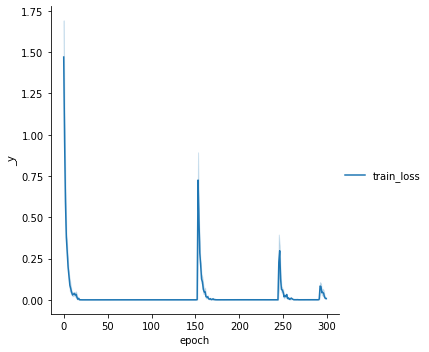

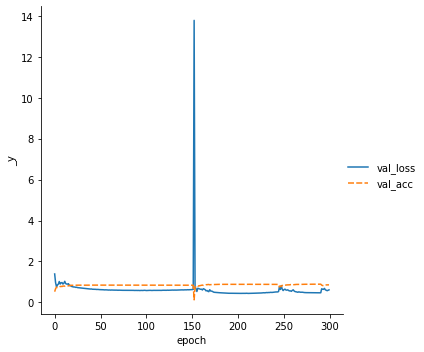

In [77]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
#display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[["train_loss"]], kind="line")
sn.relplot(data=metrics[["val_loss", "val_acc"]], kind="line")

In [78]:
trainer.test(model, testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8519999980926514
        test_loss            0.616338849067688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.616338849067688, 'test_acc': 0.8519999980926514}]

# AutoAugment Data

In [16]:
transform_train = transforms.Compose(
    [   transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

batch = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2,len(testset)-len(testset)//2])


valloader = torch.utils.data.DataLoader(validationset, batch_size=batch,
                                         shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
model = Net(myCNN(), lr = 1e-2)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=20,
    logger=CSVLogger(save_dir="myCNNlogs/"),
)

trainer.fit(model, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type     | Params
--------------------------------------------
0 | net            | myCNN    | 13.4 M
1 | train_accuracy | Accuracy | 0     
2 | val_accuracy   | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


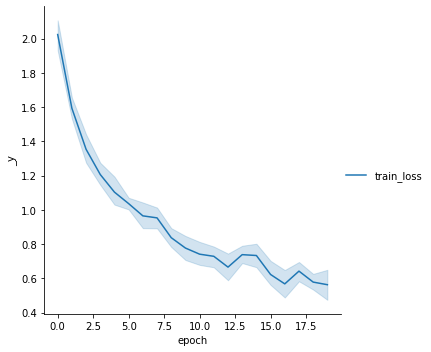

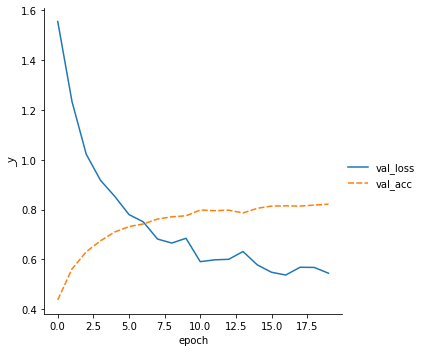

In [18]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
#display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[["train_loss"]], kind="line")
sn.relplot(data=metrics[["val_loss", "val_acc"]], kind="line")

In [19]:
trainer.test(model, testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8361999988555908
        test_loss           0.5128878355026245
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5128878355026245, 'test_acc': 0.8361999988555908}]

# Variational Autoencoder (VAE):

In [386]:
train_size = 50000 
batch_size = 32
test_size = 10000

epochs = 50
latent_dim = 512
num_examples_to_generate = 16


In [387]:
(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
  images = images.reshape((images.shape[0], 32, 32, 3)) / 255.
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [388]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(1, 1), activation='relu', padding='same',),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(1, 1), activation='relu', padding='same',),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=256, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=512, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*512, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 512)),
            tf.keras.layers.Conv2DTranspose(
                  filters=512, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                  filters=256, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                  filters=128, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=1, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=1, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def call(self, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)

In [389]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    #print(predictions[i, :, :,].shape)
    plt.imshow(predictions[i, :, :,])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [390]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [391]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
model.build((batch_size,32, 32, 3))
model.summary()

Model: "cvae_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_123 (Sequential)  (None, 1024)             6288192   
                                                                 
 sequential_124 (Sequential)  (None, 32, 32, 3)        8130371   
                                                                 
Total params: 14,418,563
Trainable params: 14,418,563
Non-trainable params: 0
_________________________________________________________________


Epoch: 50, Test set ELBO: -1824.25634765625


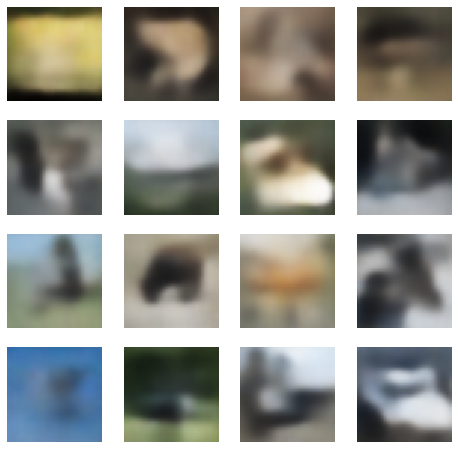

In [392]:
optimizer = tf.keras.optimizers.Adam(1e-3)

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}'.format(epoch, elbo))
  generate_and_save_images(model, epoch, test_sample)
